<a href="https://colab.research.google.com/github/sidshrivastav/Melanoma-Detection/blob/main/siddhant_shrivastav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing all the important libraries

In [22]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
from tensorflow import keras

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# Root path for dataset
root_path = 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/'

In [25]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_path+"Train")
data_dir_test = pathlib.Path(root_path+'Test')


In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Count of train images: " + str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Count of test images: " + str(image_count_test))

Count of train images: 2239
Count of test images: 118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset


Define some parameters for the loader:

In [27]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [28]:
# Train Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [29]:
# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [30]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


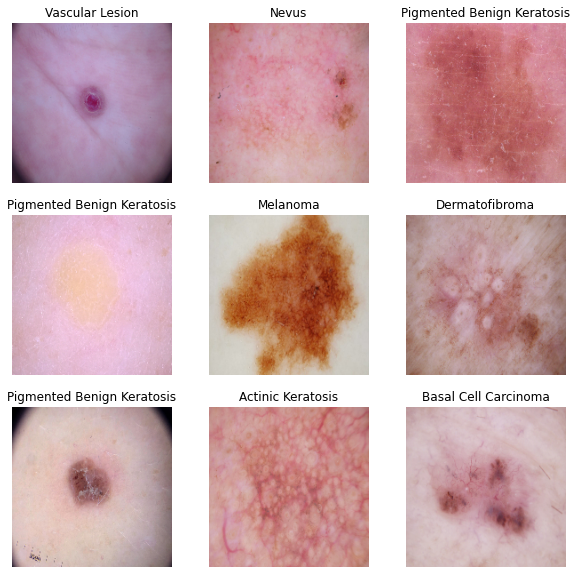

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]].title())
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [33]:
# model architecture
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(9))
model.add(keras.layers.Activation('softmax'))

### Compile the model

In [36]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Train the model

In [37]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 145s 2s/step - loss: 148.5283 - accuracy: 0.2093 - val_loss: 1.9848 - val_accuracy: 0.2371
Epoch 2/20
56/56 [==============================] - 119s 2s/step - loss: 2.0698 - accuracy: 0.2651 - val_loss: 1.9987 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 124s 2s/step - loss: 1.9360 - accuracy: 0.2997 - val_loss: 1.9645 - val_accuracy: 0.2573
Epoch 4/20
56/56 [==============================] - 119s 2s/step - loss: 1.8133 - accuracy: 0.3231 - val_loss: 2.0353 - val_accuracy: 0.2975
Epoch 5/20
56/56 [==============================] - 117s 2s/step - loss: 1.8091 - accuracy: 0.3772 - val_loss: 1.9604 - val_accuracy: 0.3221
Epoch 6/20
56/56 [==============================] - 116s 2s/step - loss: 1.6246 - accuracy: 0.4408 - val_loss: 1.9012 - val_accuracy: 0.3512
Epoch 7/20
56/56 [==============================] - 120s 2s/step - loss: 1.7025 - accuracy: 0.4023 - val_loss: 1.9684 - val_accuracy: 0.3848
Epoch 8/20
56/56 [====

### Visualizing training results

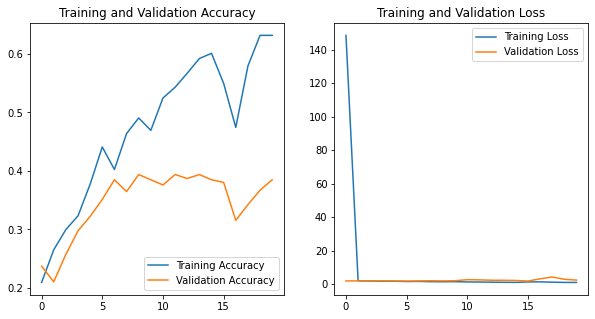

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

Here we can see that in model is overfitting due to:
- In accuracy graph, training is very high where validation is half of it.
- In loss graph, 

### Re-create Model

In [39]:
# model architecture
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.50))
model.add(keras.layers.Dense(9))
model.add(keras.layers.Activation('softmax'))

### Re-compile Model

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Re-train Model

In [41]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 128s 2s/step - loss: 985.3589 - accuracy: 0.1970 - val_loss: 2.1847 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 126s 2s/step - loss: 2.0047 - accuracy: 0.2455 - val_loss: 2.1603 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 125s 2s/step - loss: 1.9887 - accuracy: 0.2690 - val_loss: 2.1423 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 125s 2s/step - loss: 1.9425 - accuracy: 0.2974 - val_loss: 2.1409 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 125s 2s/step - loss: 1.9384 - accuracy: 0.2930 - val_loss: 2.1171 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 125s 2s/step - loss: 1.9109 - accuracy: 0.3052 - val_loss: 2.1139 - val_accuracy: 0.1969
Epoch 7/20
56/56 [==============================] - 125s 2s/step - loss: 1.8770 - accuracy: 0.3253 - val_loss: 2.1087 - val_accuracy: 0.2058
Epoch 8/20


### Visualizing training results

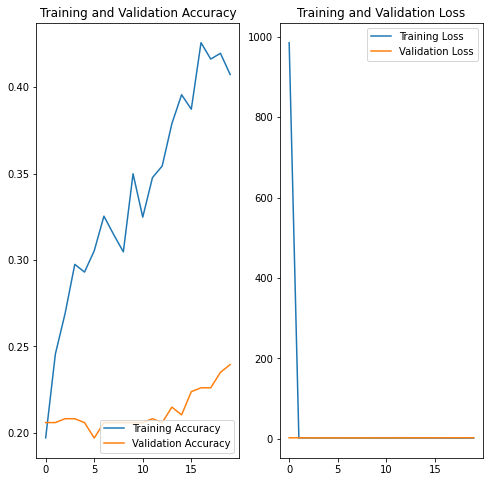

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()